# Classify real data as model-free or model-based

### Import packages and set plotting settings

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys 
sys.path.append("/Users/johnzhou/research/decision-making")

from src.features.losses import mse_loss
from src.features.fit_curves import get_sigmoid_feats, epsilon_sigmoid
from src.data.real_data import RealSessionDataset, convert_real_actions
from src.data.synth_data import SynthBlockDataset
from src.data.environments import DynamicForagingTask
from src.data.experiments import RealExperiment
from src.utils import blockify, build_config, normalize_choice_block_side, average_choice_blocks, truncate_blocks
from src.models.hmm import HistogramHMM
from src.visualization.plot_replications import plot_fitted_block, plot_sigmoids

from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

In [19]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "light navy",
    "faded green",
    "dusty purple",
    "orange",
    "windows blue",
    "marigold",
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

### Load all real data filenames

In [20]:
directory = "/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging"
filenames = []
for filename in sorted(os.listdir(directory)):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        filenames.append(f)
print(f"Loaded {len(filenames)} session files")

Loaded 48 session files


### Preprocess choice data

In chronological order of session for a given mouse
1. Remove trials with no-choice (nans)
2. Compute block lengths after nan removal
3. Partition actions into blocks
4. Normalize actions by correct side
5. Truncate action blocks at trial 15, remove blocks shorter than that
6. Append to list

In [21]:
fit_loss = mse_loss

mouse_block_count = 0
choice_blocks = []
block_bounds = []

mouse_name = "MR16"
print(f"Loading data for mouse {mouse_name}")

for idx, filename in enumerate(sorted(filenames)):
    if mouse_name not in filename:
        continue
#     try:
    expt = RealExperiment(filename, task_type=DynamicForagingTask)
#     except ValueError:
#         print(f"Failed to load {filename}")
#         continue
        
    session_block_count = 0
    truncated_blocks = expt.get_preprocessed_blocks(min_len=15)
    
    choice_blocks += truncated_blocks
    session_block_count += len(truncated_blocks)
    mouse_block_count += len(truncated_blocks)
    
    print(f"{filename} yields {session_block_count}")
    block_bounds.append(mouse_block_count)


Loading data for mouse MR16
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221006_152352.mat yields 11
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221007_160919.mat yields 8
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221010_140416.mat yields 4
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221011_132928.mat yields 8
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221012_110414.mat yields 13
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221013_115356.mat yields 13
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221014_124744.mat yields 11
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221017_130617.mat yields 11
/Users/johnzhou/research/decisi

In [22]:
print(block_bounds)

[11, 19, 23, 31, 44, 57, 68, 79, 95, 105, 121, 138]


### Fit real, preprocessed blocks with sigmoid function and get parameters

In [23]:
sigmoids = []
sigmoid_params = get_sigmoid_feats(choice_blocks, fit_loss, plot=False)
sigmoids.append(sigmoid_params)

100%|███████████████████████████████████████| 138/138 [00:00<00:00, 1020.18it/s]


### Load data for HistHMM

In [24]:
expt_name = "generate_ssm_histogram"
repo_path = "/Users/johnzhou/research/decision-making"
expt_data = SynthBlockDataset(expt_name, repo_path)
boundary = list(expt_data.agent_labels == 1).index(True)

epsilon_bins = np.linspace(np.min(expt_data.sigmoid_parameters[:, 0]), np.max(expt_data.sigmoid_parameters[:, 0]), 100)
alpha_bins = np.linspace(np.min(expt_data.sigmoid_parameters[:, 1]), np.max(expt_data.sigmoid_parameters[:, 1]), 100)
offset_bins = np.linspace(np.min(expt_data.sigmoid_parameters[:, 2]), np.max(expt_data.sigmoid_parameters[:, 2]), 100)

mf_hist, mf_bins = np.histogramdd(expt_data.sigmoid_parameters[:boundary, :], bins=[epsilon_bins, alpha_bins, offset_bins])
mb_hist, mb_bins = np.histogramdd(expt_data.sigmoid_parameters[boundary:, :], bins=[epsilon_bins, alpha_bins, offset_bins])
emission_hists = [mf_hist / np.sum(mf_hist), mb_hist / np.sum(mb_hist)]
emission_bins = [mf_bins, mb_bins]

hist_model = HistogramHMM(2, 3, emission_hists, emission_bins, random_state=idx)

### Delete any real data that falls outside the histogram (should be none, if so we have a problem)

In [25]:
X = np.squeeze(np.array(sigmoids))
lls = hist_model._compute_log_likelihood(X)
invalid_idxs = np.argwhere(np.all(lls==np.array([np.NINF, np.NINF]), axis=1)).flatten()
print(invalid_idxs)

X = np.delete(X, invalid_idxs, axis=0)
time_bins = X.shape[0]

[]


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


## Fit models

### Fit HistHMM with different random states

In [26]:
print(X.shape)
models = []
scores = []
transmat = np.array([[0.5, 0.5],
                    [0.5, 0.5]])
for idx in range(10):
    # define our hidden Markov model
    model = HistogramHMM(2, 3, emission_hists, emission_bins, random_state=idx)
    model.fit(X)
    models.append(model)
    scores.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}'
          f'\tScore: {scores[-1]}')

hist_model = models[np.argmax(scores)]
n_states = hist_model.n_components
print(f'The best model had a score of {max(scores)} and {n_states} '
      'states')
hist_predicted_states = hist_model.predict(X)
print(hist_predicted_states)

/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


(138, 3)
Normalized histogram for state 0.
Normalized histogram for state 0.
Converged: True	Score: -477.06408450619944
Normalized histogram for state 0.


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -477.06411145696944
Converged: True	Score: -477.07768811476416


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -477.0634185766413
Converged: True	Score: -477.06435764974844


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -477.06905053260164
Converged: True	Score: -477.0639357057702


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -477.06348583319016
Converged: True	Score: -477.0629510248158
Converged: True	Score: -477.06362659830387
The best model had a score of -477.0629510248158 and 2 states
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1
 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1
 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1]


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


### Fit GaussianHMM with different random states

In [27]:
scores = []
models = []

for idx in range(10):
    # define our hidden Markov model
    model = GaussianHMM(n_components=2,
                            covariance_type='full',
                            random_state=idx)
    model.fit(X)  # 50/50 train/validate
    models.append(model)
    scores.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}'
          f'\tScore: {scores[-1]}')

gaussian_model = models[np.argmax(scores)]
n_states = gaussian_model.n_components
print(f'The best model had a score of {max(scores)} and {n_states} '
      'states')
predicted_states = gaussian_model.predict(X)
print(predicted_states)

Converged: True	Score: -227.23783008416862
Converged: True	Score: -227.31525984801047
Converged: True	Score: -227.25120962860103
Converged: True	Score: 1286.3855495622552
Converged: True	Score: 254.55150573732618
Converged: True	Score: 256.18330917736716
Converged: True	Score: -227.21790502398974
Converged: True	Score: -227.96619893784256
Converged: True	Score: -227.22107960152692
Converged: True	Score: -205.89047037678188
The best model had a score of 1286.3855495622552 and 2 states
[0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0
 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1]


### Fit Gaussian HMM from SSM library

In [28]:
num_states = 2
obs_dim = 3
obs_model = "gaussian"
N_iters = 1000
fit_method = "em"

hmm = ssm.HMM(num_states, obs_dim, observations=obs_model) 
hmm_lls = hmm.fit(X, method=fit_method, num_em_iters=N_iters, init_method="kmeans")

hmm_z = hmm.most_likely_states(X)

LP: -227.2: 100%|████████████████████████████| 100/100 [00:00<00:00, 230.27it/s]


## Plot most-likely sequence results

Rerun the below cells to flip colors for GaussianHMMs, in case the states look flipped

In [42]:
predicted_states = 1 - predicted_states

In [30]:
hmm_z = 1 - hmm_z

([], [])

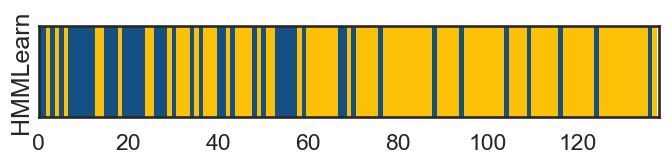

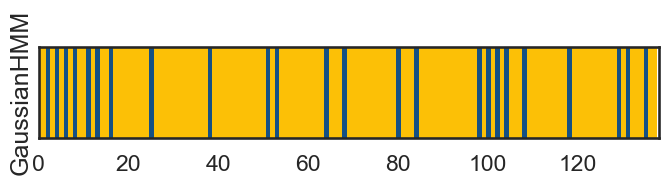

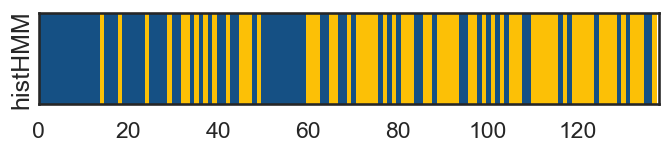

In [43]:
plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.imshow(predicted_states[None,:], aspect="auto", cmap=cmap)
# plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
plt.ylim(0, 0.5)
plt.xlim(0, time_bins)
plt.ylabel("HMMLearn")
plt.yticks([])

plt.figure(figsize=(8, 4))
plt.subplot(312)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap)
# plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
plt.ylim(0, 0.5)
plt.xlim(0, time_bins)
plt.ylabel("GaussianHMM")
plt.yticks([])

hist_plot = np.array([-1 if state == 0 else state for state in hist_predicted_states])

plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.imshow(hist_predicted_states[None,:], aspect="auto", cmap=cmap)
# plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
plt.ylim(0, 0.5)
plt.xlim(0, time_bins)

plt.ylabel("histHMM")
plt.yticks([])

# plt.savefig(f'/Users/johnzhou/Desktop/{mouse_name}_predicted_states.pdf', format='pdf')

### Plot percentage of model-based blocks per session from HistHMM

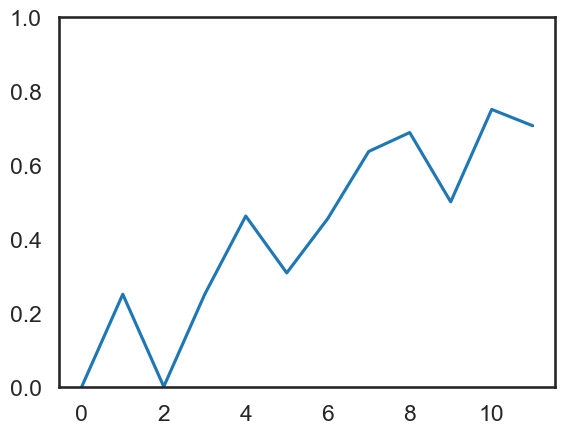

In [32]:
new_bounds = [0] + block_bounds
new_bounds = list(np.unique(np.array(new_bounds)))
indices = [(new_bounds[i], new_bounds[i+1]) for i in range(len(new_bounds) - 1)]

percent_mb = [np.mean(hist_predicted_states[start:end]) for start, end in indices]
plt.figure()
plt.ylim([0, 1])
plt.plot(percent_mb)

# plt.savefig(f'/Users/johnzhou/Desktop/{mouse_name}_mb_percentage.eps', format='eps')

### Plot all sigmoid curves for each state

In [33]:
def visualize_sigmoids(sigmoid_params, idxs):
    params_list = sigmoid_params[idxs.flatten(), ...]
    plot_sigmoids(epsilon_sigmoid, params_list)
    
def visualize_regimes(state_preds, sigmoid_params):
    plt.figure()
    plt.subplot(211)
    idxs_0 = np.argwhere(state_preds == 0)
    visualize_sigmoids(sigmoid_params, idxs_0)
    plt.figure()
    plt.subplot(212)
    idxs_1 = np.argwhere(state_preds == 1)
    visualize_sigmoids(sigmoid_params, idxs_1)

Gaussian HMM from HMMLearn

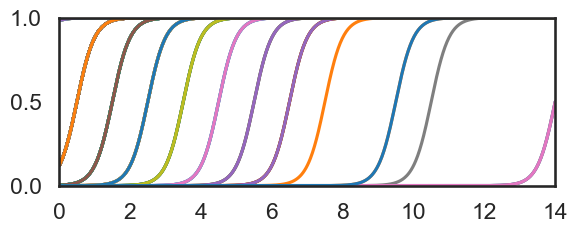

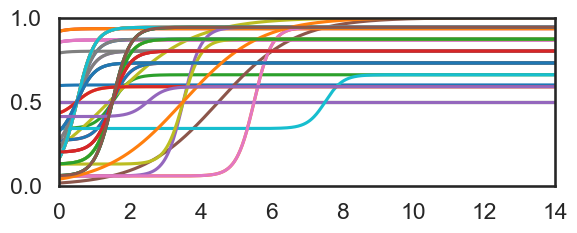

In [34]:
visualize_regimes(predicted_states, np.squeeze(X))

Gaussian HMM from SSM

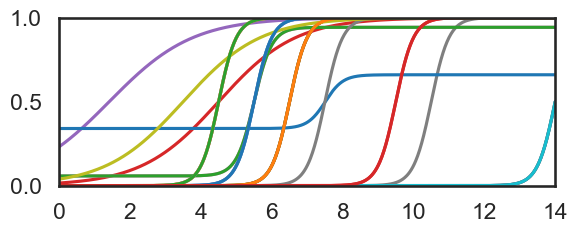

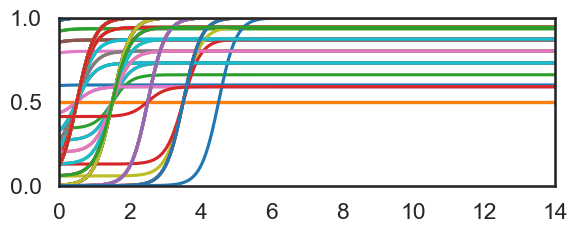

In [35]:
visualize_regimes(hmm_z, np.squeeze(X))

HistHMM

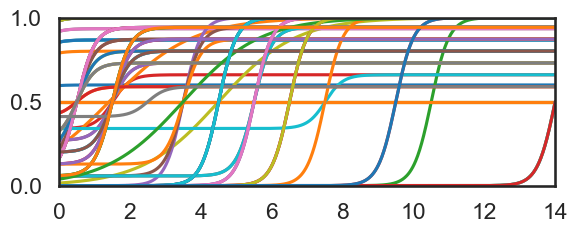

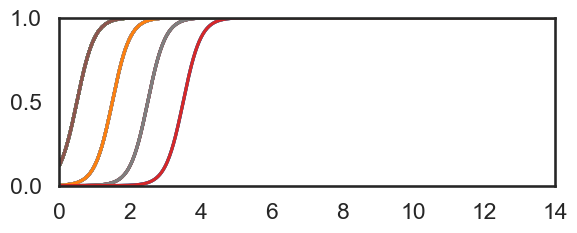

[[0.60850156 0.39149844]
 [0.47682624 0.52317376]]
Percentage model-based: 0.4782608695652174


In [36]:
visualize_regimes(hist_predicted_states, np.squeeze(X))
print(hist_model.transmat_)
print("Percentage model-based:", np.sum(hist_predicted_states)/hist_predicted_states.size)

Cluster within model-free curves

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1
 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1
 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  19
  20  21  22  23  25  26  27  28  30  31  34  36  38  40  41  43  44  48
  50  51  52  53  54  55  56  57  58  59  63  64  67  68  70  76  78  80
  84  85  88  94  95  98 100 102 104 108 109 116 118 124 129 131 135 136]
[0.1159413  3.79012286 2.79899943]


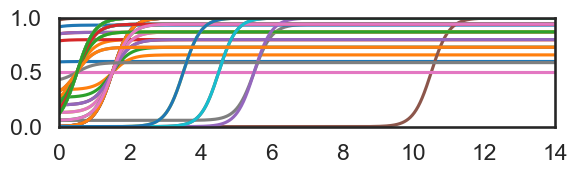

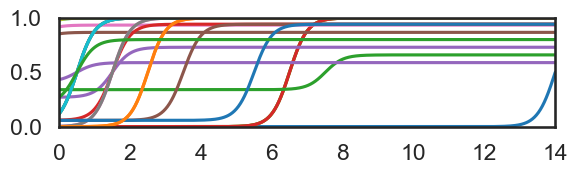

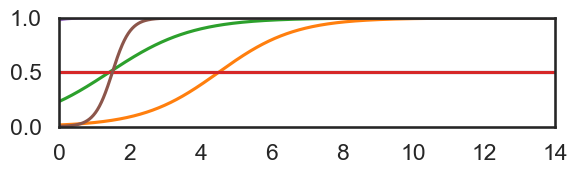

In [37]:
from sklearn.cluster import KMeans
print(hist_predicted_states)
mf_idxs = np.argwhere(1 - hist_predicted_states).flatten()
print(mf_idxs)
mf_sigs = X[mf_idxs]
print(np.mean(mf_sigs, axis=0))
mf_sigs -= np.mean(mf_sigs, axis=0)
mf_sigs /= np.std(mf_sigs, axis=0)

kmeans = KMeans(n_clusters=3).fit(mf_sigs)
# Return the cluster labels for each item in the input list of lists

state_preds = kmeans.labels_
plt.figure()
plt.subplot(311)
idxs_0 = np.argwhere(state_preds == 0)
visualize_sigmoids(sigmoid_params, idxs_0)
plt.figure()
plt.subplot(312)
idxs_1 = np.argwhere(state_preds == 1)
visualize_sigmoids(sigmoid_params, idxs_1)
plt.figure()
plt.subplot(313)
idxs_2 = np.argwhere(state_preds == 2)
visualize_sigmoids(sigmoid_params, idxs_2)

[0 2 1 0 1 0 1 0 2 0 0 2 2 1 3 0 1 0 3 0 0 0 0 0 3 1 0 0 0 3 0 0 3 3 0 3 0
 3 1 3 2 0 3 0 0 3 3 3 0 3 0 1 0 1 0 0 0 0 1 0 3 3 3 0 1 3 3 0 1 3 0 3 3 3
 3 3 0 3 0 3 1 3 3 3 1 1 3 3 0 3 3 3 3 3 0 0 3 3 1 3 1 3 1 3 2 3 3 3 1 0 3
 3 3 3 3 3 0 3 1 3 3 3 3 3 0 3 3 3 3 1 3 1 3 3 3 1 0 3]


([], [])

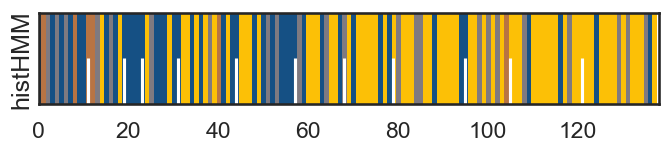

In [38]:
def assign_labels(master_array, indices, labels, fixed_value):
    # Create a copy of the master array to modify
    output_array = master_array.copy()

    # Assign the labels to the specified indices in the output array
    for index, label in zip(indices, labels):
        output_array[index] = label

    # Set all other elements in the output array to the fixed value
    output_array[np.logical_not(np.isin(range(len(output_array)), indices))] = fixed_value

    return output_array

n_labels = assign_labels(hist_predicted_states, mf_idxs, state_preds, 3)
print(n_labels)

plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.imshow(n_labels[None,:], aspect="auto", cmap=cmap)
plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
plt.ylim(0, 0.5)
plt.xlim(0, time_bins)

plt.ylabel("histHMM")
plt.yticks([])

### Plot learned transition matrix over all sessions

[[0.60850156 0.39149844]
 [0.47682624 0.52317376]]


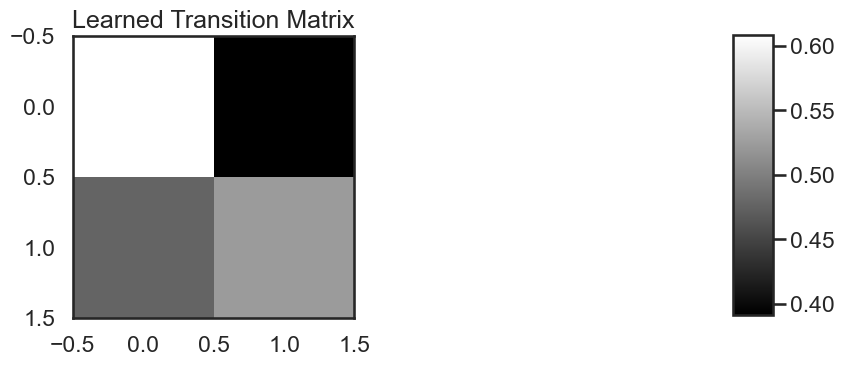

In [39]:
learned_transition_mat = hist_model.transmat_
print(learned_transition_mat)

fig = plt.figure(figsize=(8, 4))

plt.subplot(121)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

## Analyze differences in other measurements between MF and MB

In [40]:
b_block_bounds = [0] + block_bounds
print(b_block_bounds)

[0, 11, 19, 23, 31, 44, 57, 68, 79, 95, 105, 121, 138]


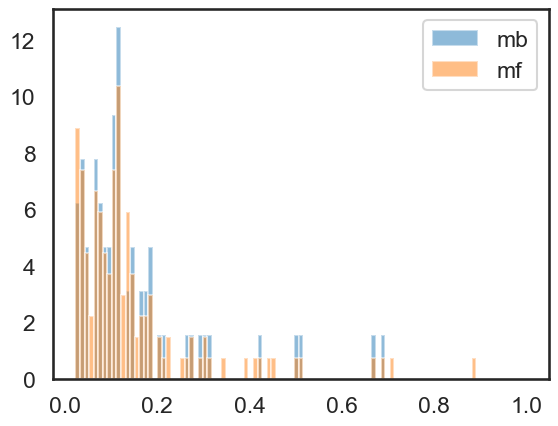

In [41]:
mb_rt = expt.reaction_time[np.argwhere(hist_predicted_states).flatten()]
mf_rt = expt.reaction_time[np.argwhere(~hist_predicted_states).flatten()]

bins = np.linspace(min(np.min(mb_rt), np.min(mf_rt)), 1, num=100)

plt.hist(mb_rt, bins=bins, alpha=0.5, label='mb', density=True)
plt.hist(mf_rt, bins=bins, alpha=0.5, label='mf', density=True)
plt.legend(loc='upper right')
plt.show()